In [1]:
import trimesh, glob, pathlib, random

In [2]:
# Get all collision obj files
all_files = set(glob.glob(r"D:\BEHAVIOR-1K\asset_pipeline\artifacts\aggregate\objects\*\*\shape\collision\*.obj"))
numbered_files = set(glob.glob(r"D:\BEHAVIOR-1K\asset_pipeline\artifacts\aggregate\objects\*\*\shape\collision\*.*.obj"))
root_files = sorted(pathlib.Path(x) for x in all_files-numbered_files)
print(root_files)

[WindowsPath('D:/BEHAVIOR-1K/asset_pipeline/artifacts/aggregate/objects/alarm/dkwmmf/shape/collision/alarm-dkwmmf-base_link.obj'), WindowsPath('D:/BEHAVIOR-1K/asset_pipeline/artifacts/aggregate/objects/almond/acooui/shape/collision/almond-acooui-base_link.obj'), WindowsPath('D:/BEHAVIOR-1K/asset_pipeline/artifacts/aggregate/objects/apple/agveuv/shape/collision/apple-agveuv-base_link.obj'), WindowsPath('D:/BEHAVIOR-1K/asset_pipeline/artifacts/aggregate/objects/apple/omzprq/shape/collision/apple-omzprq-base_link.obj'), WindowsPath('D:/BEHAVIOR-1K/asset_pipeline/artifacts/aggregate/objects/apple/qusmpx/shape/collision/apple-qusmpx-base_link.obj'), WindowsPath('D:/BEHAVIOR-1K/asset_pipeline/artifacts/aggregate/objects/apple/sguztn/shape/collision/apple-sguztn-base_link.obj'), WindowsPath('D:/BEHAVIOR-1K/asset_pipeline/artifacts/aggregate/objects/apricot/inxcvi/shape/collision/apricot-inxcvi-base_link.obj'), WindowsPath('D:/BEHAVIOR-1K/asset_pipeline/artifacts/aggregate/objects/apricot/qmwm

In [3]:
import logging
logger = logging.getLogger("trimesh")
logger.setLevel(logging.ERROR)

In [43]:
import numpy as np
import trimesh.voxel.creation
import io

def voxelize(m):
    pitch = 0.01
    return trimesh.voxel.creation.local_voxelize(
        m, pitch=pitch, point=np.array([0, 0, 0]),
        radius=int(np.ceil(0.5/pitch))
    ).matrix

def compute_iou(visual_mesh, collision_mesh):
    v_collision = voxelize(hull_count_mesh)

    # Compute their intersection volume
    intersection = v_max_mesh & v_hull_count_mesh
    intersection_cnt = np.count_nonzero(intersection)
    union = v_max_mesh | v_hull_count_mesh
    union_cnt = np.count_nonzero(union)
    iou = intersection_cnt / union_cnt

    memory[hull_count] = (hull_count_mesh, iou)

    return iou

def load_analyze_object(client, root_fn):
    # Load the visual mesh
    visual_fn = pathlib.Path(str(root_fn).replace("collision", "visual"))
    assert visual_fn.exists(), str(visual_fn)
    with open(visual_fn, "rb") as f:
        visual_content = f.read()
    
    contents = []
    for hull_count in [2, 4, 8, 16, 32, 64]:
        hull_count_fn = root_fn.with_suffix(f".{hull_count}.obj")
        assert hull_count_fn.exists(), str(hull_count_fn)
        with open(hull_count_fn, "rb") as f:
            contents.append(f.read())
            
    # Now call analyze object
    return client.submit(analyze_object, contents, visual_content, key=str(root_fn)).result()

In [5]:
from dask.distributed import Client

dask_client = Client('sc.stanford.edu:35423', direct_to_workers=True)

C:\Users\Cem\.conda\envs\pipeline\lib\site-packages\distributed\client.py:1361: VersionMismatchWarning: Mismatched versions found

+-------------+--------+-----------+---------+
| Package     | Client | Scheduler | Workers |
+-------------+--------+-----------+---------+
| cloudpickle | 2.1.0  | 2.2.1     | 2.2.1   |
| lz4         | 4.3.2  | None      | None    |
| numpy       | 1.22.3 | 1.24.2    | 1.24.2  |
| pandas      | 1.4.3  | None      | None    |
| tornado     | 6.1    | 6.2       | 6.2     |
+-------------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [6]:
from concurrent import futures
import tqdm

all_futures = {}
results = {}
randomized_root_files = list(root_files)
random.shuffle(randomized_root_files)
executor = futures.ThreadPoolExecutor(max_workers=100)
for rfn in tqdm.tqdm(randomized_root_files[:1000]):
    all_futures[executor.submit(load_analyze_object, dask_client, rfn)] = rfn

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7598.61it/s]


In [40]:
print(sum(1 for f in all_futures.keys() if f.done()), "/", len(all_futures))

997 / 1000


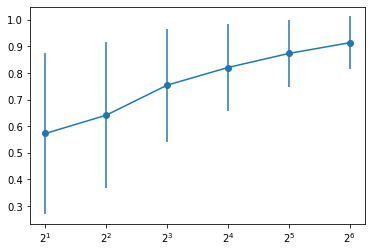

In [38]:
# Temporarily process returned futures
results = {rfn: f.result() for f, rfn in all_futures.items() if f.done() and not f.exception()}
vals = np.array(list(results.values()))
x = np.array([2, 4, 8, 16, 32, 64])
y = np.mean(vals, axis=0)
std = np.std(vals, axis=0)

import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.xscale("log", base=2)
plt.errorbar(x, y, std)
plt.show()

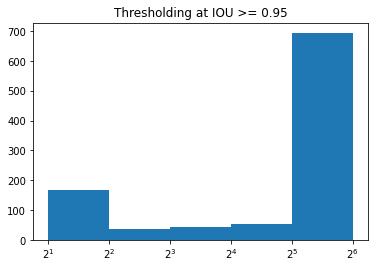

0.95 64.0 44.3714859437751 26.80006575174761


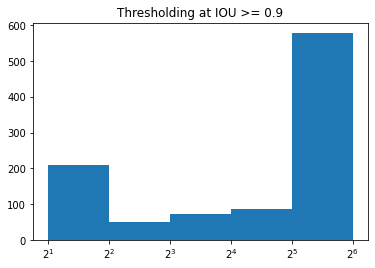

0.9 32.0 35.91967871485944 27.357399061879264


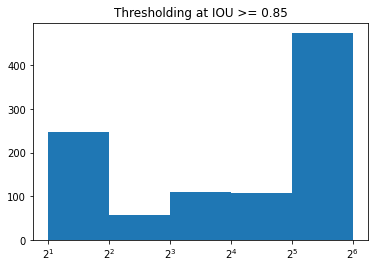

0.85 16.0 28.674698795180724 25.943919330172154


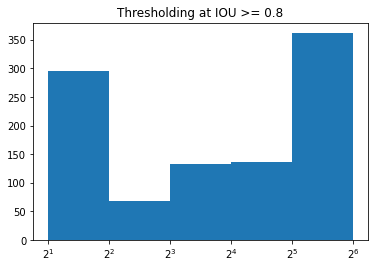

0.8 16.0 21.967871485943775 23.04141050979026


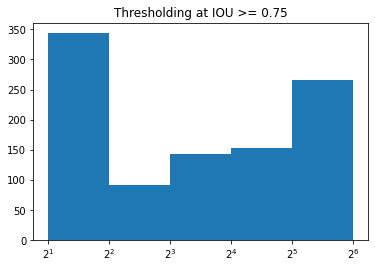

0.75 8.0 17.016064257028113 20.05163372476207


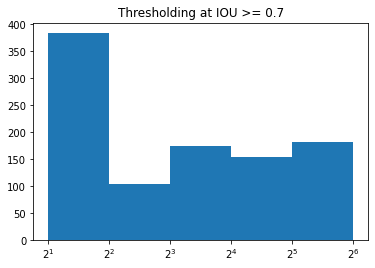

0.7 8.0 13.269076305220883 17.17743124354476


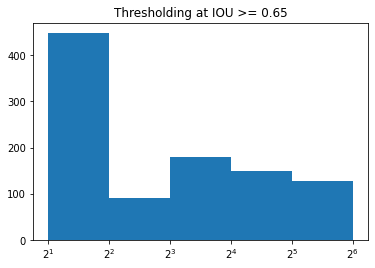

0.65 4.0 10.518072289156626 14.134348017304948


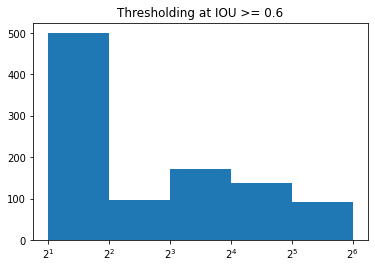

0.6 2.0 8.698795180722891 12.03382275566146


In [39]:
thresholds = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]
for threshold in thresholds:
    usable_option = np.argmax(np.concatenate([vals, np.ones(len(vals))[:, None]], axis=1) >= threshold, axis=1)
    usable_option[usable_option==6] = 5
    x_vals = x[usable_option]
    plt.hist(x_vals, bins=x)  # arguments are passed to np.histogram
    plt.xscale("log", base=2)
    plt.title(f"Thresholding at IOU >= {threshold}")
    plt.show()
    print(threshold, np.median(x_vals), np.mean(x_vals), np.std(x_vals))

In [19]:
vals

array([[0.18578021, 0.20212326, 0.63894313, 0.70297085, 0.87641994,
        0.96997441],
       [0.66292135, 0.76236114, 0.94410023, 0.98223279, 0.97888216,
        0.9843706 ],
       [0.73150024, 0.75448029, 0.85837729, 0.85561019, 0.85695127,
        0.83568075],
       ...,
       [0.87795741, 0.93042206, 0.94097736, 0.9508406 , 0.97585382,
        0.98596799],
       [0.92781615, 0.95298967, 0.98135656, 0.99384609, 0.9919843 ,
        0.99879473],
       [0.99372707, 0.9943128 , 0.99726679, 0.99466888, 0.99596679,
        0.99667853]])

In [ ]:
if False:
    for future in all_futures.keys():
        if future.done():
        try:
            result = future.result(timeout=0)
            rfn = all_futures[future]
            results[rfn] = result
        except:
            print("\n", all_futures[future], " ran into an error:")
            print(traceback.format_exc())